In [4]:
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import math
import random
import json

print("Modules loaded")

Modules loaded


In [5]:
flightDf = pd.read_json("./input/flight-vector.json")

fedDf = pd.read_json("./input/fed-list.json")

print(flightDf.head())
print(flightDf.size)

print(fedDf.head())
print(fedDf.size)

   FlightPathId  Rcvr  HasSig    Icao    Bad                FSeen  CMsgs  \
0      11352471   102   False  AD3997  False  08/05/2020 07:00:30      1   
1      11021170   102   False  A82B72  False  08/05/2020 07:00:29      1   
2      10796473   102   False  A4BDB9  False  08/05/2020 07:00:26      2   
3      10798030   102   False  A4C3CE  False  08/05/2020 07:00:26      3   
4      10669660   102   False  A2CE5C  False  08/05/2020 07:00:22      4   

      GAlt       InHg  AltT  ...  other_names_2  other_names_3  other_names_4  \
0      NaN  29.911417     0  ...           None           None           None   
1   3701.0  30.121063     0  ...           None           None           None   
2  15710.0  30.029528     0  ...           None           None           None   
3    671.0  29.940945     0  ...           None           None           None   
4  45085.0  30.029528     0  ...           None           None           None   

   other_names_5  expiration_date  unique_id  kit_mfr  k

In [74]:
def in_bounds(pos_vector_df, bounds):
    if pos_vector_df["Lat"].min() >= bounds[2] and pos_vector_df["Lat"].max() <= bounds[3]:
        if pos_vector_df["Long"].min() >= bounds[0] and pos_vector_df["Long"].max() <= bounds[1]:
            return True
    return False


def filter_pos_vector_df(pos_vector_df, bounds):
    # print(pos_vector)
    df = pd.DataFrame(pos_vector_df)
    in_bounds = (df["Lat"] >= bounds[2]) & (df["Lat"] <= bounds[3]) & (df["Long"] <= bounds[1]) & (df["Long"] >= bounds[0])
    # print(in_bounds)
    # # df = df[df[in_bounds]]

    return df[in_bounds]


def get_distance(coords):
    distance = 0
    for i in range(len(coords)):
        if i < len(coords) - 1:
            distance += math.sqrt((coords[i+1][1]-coords[i][1])**2+(coords[i+1][0]-coords[i][0])**2)
    return distance

def get_displacement(pos_vector):
    df1 = pos_vector["Long"]
    long1 = df1.iat[0]
    long2 = df1.iat[-1]
    
    lat1 = pos_vector.iloc[0]["Lat"]
    lat2 = pos_vector.iloc[-1]["Lat"]
#     print(df1)
#     df2 = pos_vector.iloc[-1]
#     print()
#     print(df2)
#     print()
    long = np.array((long1, long2))
    lat = np.array((pos_vector["Lat"].iloc[0], pos_vector["Lat"].iloc[-1]))
#     longArr = long.to_numpy()
#     latArr = lat.to_numpy()
#     print(longArr)
#     print(latArr)
#     print()
    coords = np.stack((longArr, latArr), axis=1)
#     print(coords)
    return get_distance(coords)


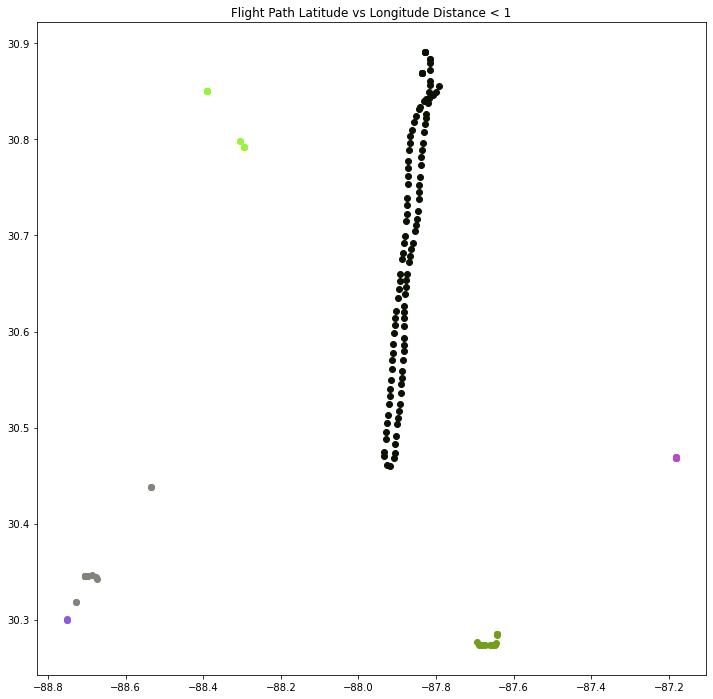

In [75]:
b_box = (-89, -87, 30, 32)

distances = []

flight_coord_pairs = []
plt.rcParams["figure.figsize"] = (12, 12)


for index, row in flightDf.iterrows():
    pos_vector_df = pd.DataFrame(row["pos_vector"])
    if in_bounds(pos_vector_df, b_box):
        pos_vector_df["PosTime"] = pd.to_datetime(pos_vector_df.PosTime)
        pos_vector_df.sort_values(by=["PosTime"])
        long, lat = pos_vector_df["Long"], pos_vector_df["Lat"]
        longArr = long.to_numpy()
        latArr = lat.to_numpy()
        coords = np.stack((longArr, latArr), axis=1)

        distance = get_distance(coords)
        displacement = get_displacement(pos_vector_df)
        coord_pair = (distance, displacement)
        flight_coord_pairs.append(coord_pair)
        distances.append(distance)
        if distance < 1.0:

            r = random.random()
            b = random.random()
            g = random.random()
            color = (r, g, b)
            plt.scatter(longArr, latArr, color=color)
plt.title("Flight Path Latitude vs Longitude Distance < 1")
plt.show()




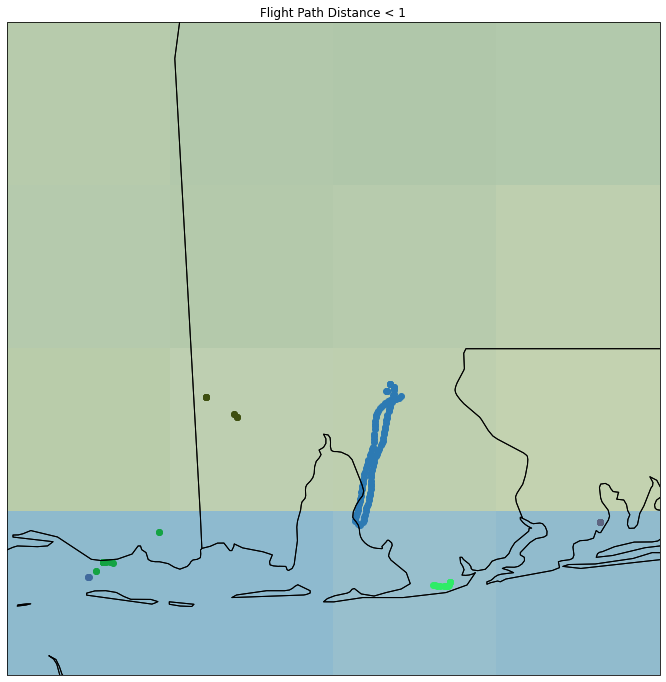

In [76]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(b_box, crs=ccrs.PlateCarree())
plt.rcParams["figure.figsize"] = (8,8)
ax.coastlines()
ax.stock_img()
ax.add_feature(cfeature.STATES)

flightRows = []


plt.title("Flight Path Distance < 1")

for index, row in flightDf.iterrows():
    pos_vector_df = pd.DataFrame(row["pos_vector"])
    if in_bounds(pos_vector_df, b_box):
        pos_vector_df["PosTime"] = pd.to_datetime(pos_vector_df.PosTime)
        pos_vector_df.sort_values(by=["PosTime"])
        long, lat = pos_vector_df["Long"], pos_vector_df["Lat"]
        longArr = long.to_numpy()
        latArr = lat.to_numpy()
        coords = np.stack((longArr, latArr), axis=1)

        distance = get_distance(coords)
        distances.append(distance)
        if distance < 1.0:
            flightRows.append(row)
            r = random.random()
            b = random.random()
            g = random.random()
            color = (r, g, b)
            plt.scatter(longArr, latArr, color=color)

plt.show()

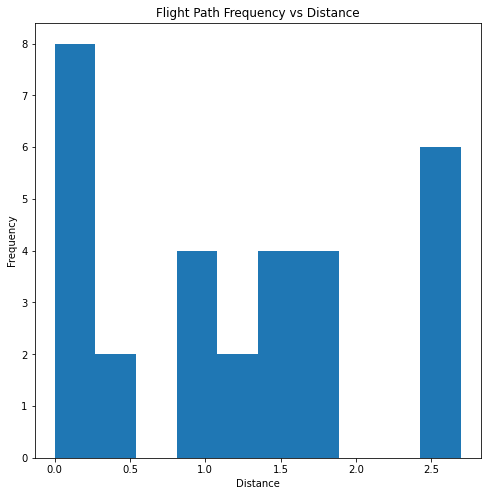

In [77]:
plt.title("Flight Path Frequency vs Distance")
plt.xlabel("Distance")
plt.ylabel("Frequency")

plt.hist(distances)
plt.show()

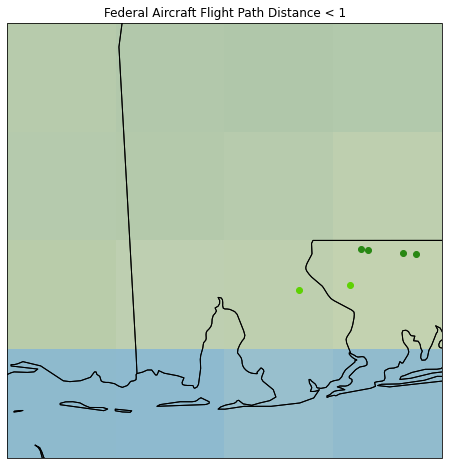

In [78]:
fedDistances = []
fedPosVector = fedDf["pos_vector"]

fedRows = []

fed_coord_pairs = []

# b_box_fed = (-125, -65, 25, 50)
b_box = (-89, -87, 30, 32)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(b_box, crs=ccrs.PlateCarree())
plt.rcParams["figure.figsize"] = (8,8)
ax.coastlines()
ax.stock_img()
ax.add_feature(cfeature.STATES)

plt.title("Federal Aircraft Flight Path Distance < 1")

for index, row in fedDf.iterrows():
    fedPosVector = pd.DataFrame(row["pos_vector"])
    if in_bounds(fedPosVector, b_box):
        fedPosVector["PosTime"] = pd.to_datetime(fedPosVector.PosTime)
        fedPosVector.sort_values(by=["PosTime"])
        long, lat = fedPosVector["Long"], fedPosVector["Lat"]
        longArr = long.to_numpy()
        latArr = lat.to_numpy()
        coords = np.stack((longArr, latArr), axis=1)

        distance = get_distance(coords)
        fedDistances.append(distance)
        
        displacement = get_displacement(fedPosVector)
        coord_pairs = (distance, displacement)
        
        fed_coord_pairs.append(coord_pairs)
        

        if distance < 1.0:
            fedRows.append(row)
            r = random.random()
            b = random.random()
            g = random.random()
            color = (r, g, b)
            plt.scatter(longArr, latArr, color=color)
plt.show()

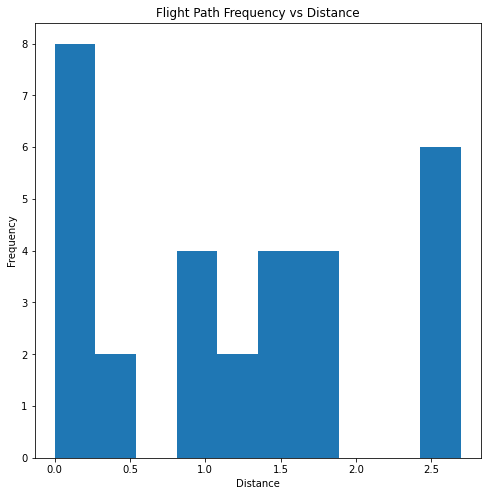

In [79]:
plt.title("Flight Path Frequency vs Distance")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.hist(distances)
plt.show()

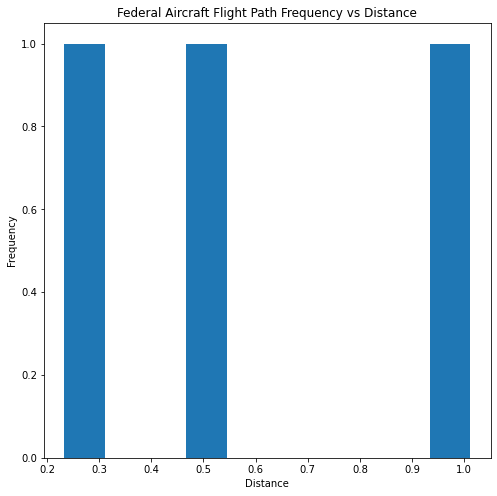

In [80]:
plt.title("Federal Aircraft Flight Path Frequency vs Distance")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.hist(fedDistances)
plt.show()

In [81]:
flightRows = pd.DataFrame(flightRows)
fedRows = pd.DataFrame(fedRows)
print(flightRows.head())
print()
print(flightRows.size)

      FlightPathId  Rcvr  HasSig    Icao    Bad                FSeen  CMsgs  \
58        10928760   102   False  A6C278  False  08/05/2020 06:59:05     36   
438       10513622   102   False  A06CD6  False  08/05/2020 06:54:05    142   
1454      11038660   102   False  A86FC4  False  08/05/2020 07:02:43      1   
2650      11144105   102   False  AA0BA9  False  08/05/2020 07:56:42      7   
2651      10879346   102   False  A60172  False  08/05/2020 07:55:53     24   

        GAlt       InHg  AltT  ...  other_names_2  other_names_3  \
58    1200.0  29.920275     0  ...           None           None   
438    100.0  29.920275     0  ...           None           None   
1454  1891.0  29.911417     0  ...           None           None   
2650  1250.0  29.920275     0  ...           None           None   
2651  1991.0  29.911417     0  ...           None           None   

      other_names_4  other_names_5  expiration_date  unique_id  kit_mfr  \
58             None           None       

In [82]:
print(fedRows.head())
print()
print(fedRows.size)

          id  adshex flight_id  squawk  type  \
898    96099  A5286F   7511385    3232         
2372  274902  AAF593   7821d56    2374  DH8B   

                                             name  \
898   UNITED STATES CUSTOMS AND BORDER PROTECTION   
2372           US DEPARTMENT OF HOMELAND SECURITY   

                        other_names1            other_names2 n_number  \
898         OFFICE OF AIR AND MARINE                           N431SK   
2372  US CUSTOMS & BORDER PROTECTION  OFFICE OF AIR & MARINE   N805MR   

     serial_number  mfr_mdl_code             mfr      model year_mfr  \
898        LC-5288       5260217        LOCKHEED        P3B            
2372           655       1390007  BOMBARDIER INC  DHC-8-202     2008   

      type_aircraft agency                                         pos_vector  
898               5    dhs  [{'Lat': 30.9601, 'Long': -87.3744, 'Spd': 182...  
2372              5    dhs  [{'Lat': 30.7714, 'Long': -87.6578, 'Spd': 0.0...  

34


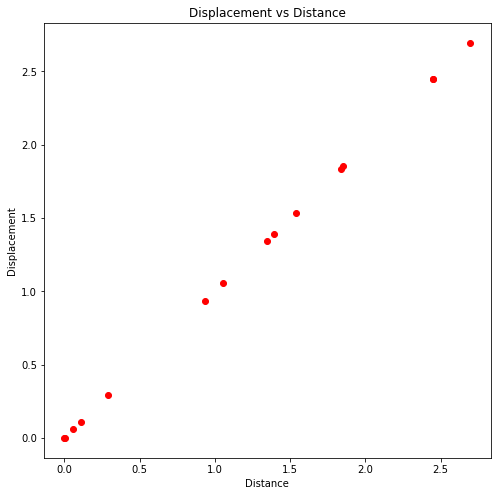

In [83]:
flightNd = pd.DataFrame(np.array(flight_coord_pairs))

plt.title("Displacement vs Distance")
plt.xlabel("Distance")
plt.ylabel("Displacement")

plt.scatter(flightNd[0], flightNd[1], color="red")

plt.show()